## Analysis of an E-commerce Dataset Part 2

The goal of the second analysis task is to train linear regression models to predict users' ratings towards items. This involves a standard Data Science workflow: exploring data, building models, making predictions, and evaluating results. In this task, we will explore the impacts of feature selections and different sizes of training/testing data on the model performance. We will use another cleaned combined e-commerce sub-dataset that **is different from** the one in “Analysis of an E-commerce Dataset” task 1.

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

### Import Cleaned E-commerce Dataset
The csv file named 'cleaned_ecommerce_dataset.csv' is provided. You may need to use the Pandas method, i.e., `read_csv`, for reading it. After that, please print out its total length.

In [1]:
# Load the data file and display the DataFrame:
import pandas as pd
df = pd.read_csv('cleaned_ecommerce_dataset.csv')
print("Length of the data: ", len(df))

# Set display width
pd.set_option('display.width', 1000)

Length of the data:  2685


In [2]:
df_summary = df.copy()

# Convert 'userId', 'item_id', 'user_city' to object data type
df_summary['userId'] = df_summary['userId'].astype('object')
df_summary['item_id'] = df_summary['item_id'].astype('object')
df_summary['user_city'] = df_summary['user_city'].astype('object')

# Summary of numerical data
numerical_columns = ['rating', 'helpfulness', 'item_price']
numerical_summary = df_summary[numerical_columns].describe().round(2)
print("\nSummary of numerical data:\n")
print(numerical_summary)

print ('------------------------------------------------------------------------------------------------------------')

# Summary of categorical data
categorical_columns = ['userId', 'gender', 'review', 'item', 'category', 'item_id', 'user_city']
categorical_summary = df_summary[categorical_columns].describe(include=['O'])
print("\nSummary of categorical data:\n")
print(categorical_summary)


Summary of numerical data:

        rating  helpfulness  item_price
count  2685.00      2685.00     2685.00
mean      3.71         3.91       83.09
std       1.35         0.29       42.23
min       1.00         3.00       12.00
25%       3.00         4.00       49.00
50%       4.00         4.00       73.65
75%       5.00         4.00      129.82
max       5.00         4.00      149.00
------------------------------------------------------------------------------------------------------------

Summary of categorical data:

        userId gender                review                  item category  item_id  user_city
count     2685   2685                  2685                  2685     2685     2685       2685
unique     267      2                  2675                    82        9       82         40
top       6408      M  Being John Malkovich  AOL (America Online)   Movies        0         27
freq        33   1407                     3                    93     1190       93        

### Explore the Dataset

* Use the methods, i.e., `head()` and `info()`, to have a rough picture about the data, e.g., how many columns, and the data types of each column.
* As our goal is to predict ratings given other columns, please get the correlations between helpfulness/gender/category/review and rating by using the `corr()` method.

  Hints: To get the correlations between different features, you may need to first convert the categorical features (i.e., gender, category and review) into numerial values. For doing this, you may need to import `OrdinalEncoder` from `sklearn.preprocessing` (refer to the useful exmaples [here](https://pbpython.com/categorical-encoding.html))
* Please provide ___necessary explanations/analysis___ on the correlations, and figure out which are the ___most___ and ___least___ correlated features regarding rating. Try to ___discuss___ how the correlation will affect the final prediction results, if we use these features to train a regression model for rating prediction. In what follows, we will conduct experiments to verify your hypothesis.

#### 1.1. Brief information about the data

In [52]:
print ('The current DataFrame: ','\n', df.head(5))
print ('---------------------------------------------------')
print (df.info())

The current DataFrame:  
    userId  timestamp                                           review                                item  rating  helpfulness gender               category  item_id  item_price  user_city
0    4081      71900                                Not always McCrap                          McDonald's     4.0          3.0      M  Restaurants & Gourmet       41       30.74          4
1    4081      72000  I dropped the chalupa even before he told me to                           Taco Bell     1.0          4.0      M  Restaurants & Gourmet       74      108.30          4
2    4081      72000                     The Wonderful World of Wendy                             Wendy's     5.0          4.0      M  Restaurants & Gourmet       84       69.00          4
3    4081     100399                             They actually did it  South Park: Bigger, Longer & Uncut     5.0          3.0      M                 Movies       68      143.11          4
4    4081     100399         

#### 1.2. The correlations between helpfulness/gender/category/review and rating

##### Convert categorical variables to numerical

In [22]:
# Convert categorical variables to numerical
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
df[['gender_code', 'category_code', 'review_code']] = ord_enc.fit_transform(df[['gender', 'category', 'review']])

print ('The current DataFrame after encoding: ','\n', df.head(5))

The current DataFrame after encoding:  
    userId  timestamp                                           review                                item  rating  helpfulness gender               category  item_id  item_price  user_city  gender_code  category_code  review_code  group_code
0    4081      71900                                Not always McCrap                          McDonald's     4.0          3.0      M  Restaurants & Gourmet       41       30.74          4          1.0            8.0       1618.0           2
1    4081      72000  I dropped the chalupa even before he told me to                           Taco Bell     1.0          4.0      M  Restaurants & Gourmet       74      108.30          4          1.0            8.0       1125.0           2
2    4081      72000                     The Wonderful World of Wendy                             Wendy's     5.0          4.0      M  Restaurants & Gourmet       84       69.00          4          1.0            8.0       2185.0    

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userId         2685 non-null   int64  
 1   timestamp      2685 non-null   int64  
 2   review         2685 non-null   object 
 3   item           2685 non-null   object 
 4   rating         2685 non-null   float64
 5   helpfulness    2685 non-null   float64
 6   gender         2685 non-null   object 
 7   category       2685 non-null   object 
 8   item_id        2685 non-null   int64  
 9   item_price     2685 non-null   float64
 10  user_city      2685 non-null   int64  
 11  gender_code    2685 non-null   float64
 12  category_code  2685 non-null   float64
 13  review_code    2685 non-null   float64
 14  group_code     2685 non-null   int64  
dtypes: float64(6), int64(5), object(4)
memory usage: 314.8+ KB


In [4]:
# Display the original and encoded 'Gender'
df[["gender", "gender_code"]].head(5)
# Each unique category along with its corresponding code
gender_code_info = df[['gender', 'gender_code']].drop_duplicates()
gender_code_info = gender_code_info.sort_values('gender_code').reset_index(drop=True)
print(gender_code_info)

  gender  gender_code
0      F          0.0
1      M          1.0


In [5]:
# Display the original and encoded 'Category'
df[["category", "category_code"]].head(5)
# Each unique category along with its corresponding code
category_code_info = df[['category', 'category_code']].drop_duplicates()
category_code_info = category_code_info.sort_values('category_code').reset_index(drop=True)
print(category_code_info)


                   category  category_code
0                     Books            0.0
1                     Games            1.0
2           Hotels & Travel            2.0
3             Kids & Family            3.0
4                     Media            4.0
5                    Movies            5.0
6  Online Stores & Services            6.0
7          Personal Finance            7.0
8     Restaurants & Gourmet            8.0


In [6]:
"""
We are working with a dataset related to customer reviews, so we might try to group categories based on the type of product or service they represent.   

For example, we could group the categories as follows:
Entertainment: Book, Games, Movies, Media

"""

'\nWe are working with a dataset related to customer reviews, so we might try to group categories based on the type of product or service they represent.   \n\nFor example, we could group the categories as follows:\nEntertainment: Book, Games, Movies, Media\n\n'

In [7]:
# Define the encoding for the new groups
group_codes = {
    "Books": 0,  # Entertainment
    "Games": 0,  # Entertainment
    "Movies": 0,  # Entertainment
    "Media": 0,  # Entertainment
    "Hotels & Travel": 1,  # Travel
    "Restaurants & Gourmet": 2,  # Restaurant
    "Kids & Family": 3,  # Kids & Family
    "Online Stores & Services": 4,  # Online Services
    "Personal Finance": 5  # Finance
}

# Create a new column for the group codes
df['group_code'] = df['category'].map(group_codes)

# Display each unique category, category_code, and group_code
group_code_info = df[['category', 'category_code', 'group_code']].drop_duplicates()
group_code_info = group_code_info.sort_values('group_code').reset_index(drop=True)
print(group_code_info)

                   category  category_code  group_code
0                    Movies            5.0           0
1                     Media            4.0           0
2                     Games            1.0           0
3                     Books            0.0           0
4           Hotels & Travel            2.0           1
5     Restaurants & Gourmet            8.0           2
6             Kids & Family            3.0           3
7  Online Stores & Services            6.0           4
8          Personal Finance            7.0           5


In [8]:
# Display the original and encoded 'Review'
df[["review", "review_code"]].head(5)
# Each unique category along with its corresponding code
review_code_info = df[['review', 'review_code']].drop_duplicates()
review_code_info = review_code_info.sort_values('review_code').reset_index(drop=True)
print(review_code_info)

                                                 review  review_code
0      &quot;What We Do In This Life Echoes In Etern...          0.0
1                                A TWELVE GAUGE WHOPPER          1.0
2      AYANKJOINSTHERAFforFROMHERETOETERNITY&spends3...          2.0
3                  Can I please get some good service?           3.0
4                       Crouching Kitty, Hidden Lizard           4.0
...                                                 ...          ...
2670                             where to not live/live       2670.0
2671                      why marry a multi-millionare?       2671.0
2672                       wow is this hard to get into       2672.0
2673            x.com - - The world's future in banking       2673.0
2674                                    you can have it       2674.0

[2675 rows x 2 columns]


##### Calculate the correlations between variables

In [25]:
# Select the columns: 'rating', 'helpfulness' and encoded variables of 'gender_code', 'category_code', 'review_code'
selected_columns = df[['rating', 'helpfulness', 'gender_code', 'category_code', 'review_code']]

# Calculate correlation matrix
correlation_matrix = selected_columns.corr()
correlation_matrix


,rating,helpfulness,gender_code,category_code,review_code
rating,1.000000,-0.007523,-0.034337,-0.163158,-0.036118
helpfulness,-0.007523,1.000000,0.075947,-0.013408,-0.028259
gender_code,-0.034337,0.075947,1.000000,0.022549,-0.037884
category_code,-0.163158,-0.013408,0.022549,1.000000,0.001970
review_code,-0.036118,-0.028259,-0.037884,0.001970,1.000000


In [ ]:
# Correlation between rating and variable
helpfulness = -0.007523
gender_code	= -0.034337
category_code = -0.163158
review_code	= -0.036118

In [32]:
# The correlations between helpfulness/gender/category/review and rating

# Correlation between helpfulness and rating
print ('Correlation between helpfulness and rating')
print (df[['helpfulness', 'rating']].corr())
print ('---------------------------------------------------')

# Correlation between gender and rating
print ('Correlation between gender and rating')
print (df[['gender_code', 'rating']].corr())
print ('---------------------------------------------------')

# Correlation between category and rating
print ('Correlation between category and rating')
print (df[['category_code', 'rating']].corr())
print ('---------------------------------------------------')

# Correlation between GROUPED CATEGORY and rating
print ('Correlation between review and rating')
print (df[['group_code', 'rating']].corr())
print ('---------------------------------------------------')

# Correlation between review and rating
print ('Correlation between review and rating')
print (df[['review_code', 'rating']].corr())
print ('---------------------------------------------------')


Correlation between helpfulness and rating
             helpfulness    rating
helpfulness     1.000000 -0.007523
rating         -0.007523  1.000000
---------------------------------------------------
Correlation between gender and rating
             gender_code    rating
gender_code     1.000000 -0.034337
rating         -0.034337  1.000000
---------------------------------------------------
Correlation between category and rating
               category_code    rating
category_code       1.000000 -0.163158
rating             -0.163158  1.000000
---------------------------------------------------
Correlation between review and rating
            group_code    rating
group_code    1.000000 -0.135336
rating       -0.135336  1.000000
---------------------------------------------------
Correlation between review and rating
             review_code    rating
review_code     1.000000 -0.036118
rating         -0.036118  1.000000
---------------------------------------------------


<Axes: >

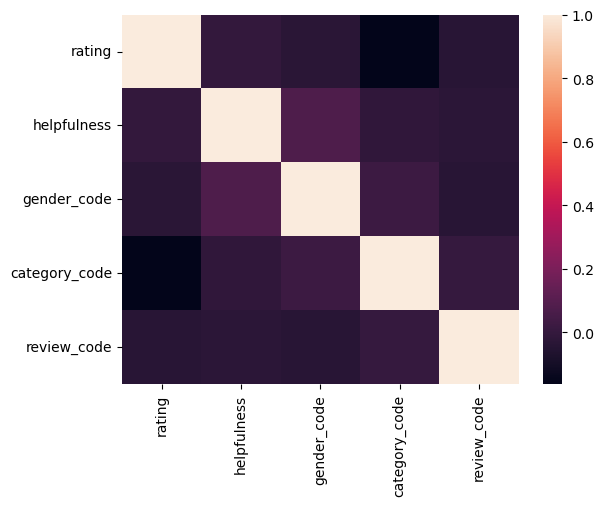

In [14]:
sns.heatmap (correlation_matrix)

In [29]:
# Select the columns: 'rating', 'helpfulness' and encoded variables of 'gender_code', 'category_code', 'review_code'
correlation_matrix2 = df[['helpfulness', 'gender_code', 'category_code', 'review_code','rating']].corr()

# Calculate correlation matrix
correlation_matrix2



,helpfulness,gender_code,category_code,review_code,rating
helpfulness,1.000000,0.075947,-0.013408,-0.028259,-0.007523
gender_code,0.075947,1.000000,0.022549,-0.037884,-0.034337
category_code,-0.013408,0.022549,1.000000,0.001970,-0.163158
review_code,-0.028259,-0.037884,0.001970,1.000000,-0.036118
rating,-0.007523,-0.034337,-0.163158,-0.036118,1.000000


<Axes: >

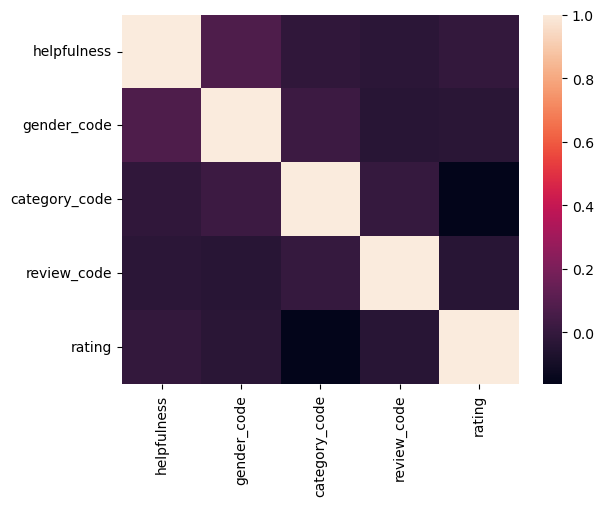

In [30]:
sns.heatmap (correlation_matrix2)

#### 1.3. Please provide necessary explanations/analysis on the correlations, and figure out which are the most and least correlated features regarding rating. Try to discuss how the correlation will affect the final prediction results, if we use these features to train a regression model for rating prediction. In what follows, we will conduct experiments to verify your hypothesis.

In [ ]:
train, test = train_test_split(iris, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #20% for test
print(X_train.shape, X_test.shape)

### Split Training and Testing Data
* Machine learning models are trained to help make predictions for the future. Normally, we need to randomly split the dataset into training and testing sets, where we use the training set to train the model, and then leverage the well-trained model to make predictions on the testing set.
* To further investigate whether the size of the training/testing data affects the model performance, please random split the data into training and testing sets with different sizes:
    * Case 1: training data containing 10% of the entire data;
    * Case 2: training data containing 90% of the entire data.
* Print the shape of training and testing sets in the two cases.

In [92]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = df.drop('rating', axis=1)
y = df['rating']

# Case 1: Training data contains 10% of the entire data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.9, random_state=142) #random_state = 142

# Case 2: Training data contains 90% of the entire data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.1, random_state=142)

# Print the shape of the training and testing sets
print("Case 1:")
print("Training set shape:", X_train_1.shape, y_train_1.shape)
print("Testing set shape:", X_test_1.shape, y_test_1.shape)

print ('---------------------------------------------------')

print("Case 2:")
print("Training set shape:", X_train_2.shape, y_train_2.shape)
print("Testing set shape:", X_test_2.shape, y_test_2.shape)

Case 1:
Training set shape: (268, 14) (268,)
Testing set shape: (2417, 14) (2417,)
---------------------------------------------------
Case 2:
Training set shape: (2416, 14) (2416,)
Testing set shape: (269, 14) (269,)


In [61]:
### Practical Workshop Method
## Split the data into training and testing sets
# Case 1: 10% of the data is used for training and 90% for testing
from sklearn.model_selection import train_test_split
train_1, test_1 = train_test_split(df, test_size=0.9, random_state=150)
print ('Training and Testing set for Case 1')
print(train_1.shape)
print(test_1.shape)
print ('---------------------------------------------------')

# Case 2: 90% of the data is used for training and 10% for testing
train_2, test_2 = train_test_split(df, test_size=0.1, random_state=150)
print ('Training and Testing set for Case 2')
print(train_2.shape)
print(test_2.shape)


Training and Testing set for Case 1
(268, 15)
(2417, 15)
---------------------------------------------------
Training and Testing set for Case 2
(2416, 15)
(269, 15)


### Train Linear Regression Models with Feature Selection under Cases 1 & 2
* When training a machine learning model for prediction, we may need to select the most important/correlated input features for more accurate results.
* To investigate whether feature selection affects the model performance, please select two most correlated features and two least correlated features from helpfulness/gender/category/review regarding rating, respectively.
* Train four linear regression models by following the conditions:
    - (model-a) using the training/testing data in case 1 with two most correlated input features
    - (model-b) using the training/testing data in case 1 with two least correlated input features
    - (model-c) using the training/testing data in case 2 with two most correlated input features
    - (model-d) using the training/testing data in case 2 with two least correlated input features
* By doing this, we can verify the impacts of the size of traing/testing data on the model performance via comparing model-a and model-c (or model-b and model-d); meanwhile the impacts of feature selection can be validated via comparing model-a and model-b (or model-c and model-d).    

* Regarding ***'rating'***:
    - <font color="orange">Two most correlated variables: ***'category (encoded)'*** and ***'review (encoded)*** </font> 
    - <font color="orange">Two least correlated variables: ***'helpfulness'*** and ***'gender (encoded)*** </font> 

#### Case 1: 10% of the data is used for training and 90% for testing

##### (Model-a) Using the training/testing data in case 1 with two most correlated input features

In [62]:
# For 'rating', two most correlated input features are 'category_code' and 'review_code'
model_a = linear_model.LinearRegression()
X_train_a = train_1[['category_code','review_code']]
y_train_a = train_1['rating']


X_test_a = test_1[['category_code','review_code']]
y_test_a = test_1['rating']

model_a.fit(X_train_a, y_train_a)


LinearRegression()

##### (Model-b) Using the training/testing data in case 1 with two least correlated input features

In [63]:
# For 'rating', two least correlated input features are 'helpfulness' and 'gender_code'
model_b = linear_model.LinearRegression()
X_train_b = train_1[['helpfulness','gender_code']]
y_train_b = train_1['rating']


X_test_b = test_1[['helpfulness','gender_code']]
y_test_b = test_1['rating']

model_b.fit(X_train_b, y_train_b)


LinearRegression()

#### Case 2: 90% of the data is used for training and 10% for testing

##### (Model-c) Using the training/testing data in case 2 with two most correlated input features

In [64]:
# For 'rating', two most correlated input features are 'category_code' and 'review_code'
model_c = linear_model.LinearRegression()
X_train_c = train_2[['category_code','review_code']]
y_train_c = train_2['rating']


X_test_c = test_2[['category_code','review_code']]
y_test_c = test_2['rating']

model_c.fit(X_train_c, y_train_c)


LinearRegression()

##### (Model-d) Using the training/testing data in case 2 with two least correlated input features

In [65]:
# For 'rating', two least correlated input features are 'helpfulness' and 'gender_code'
model_d = linear_model.LinearRegression()
X_train_d = train_2[['helpfulness','gender_code']]
y_train_d = train_2['rating']


X_test_d = test_2[['helpfulness','gender_code']]
y_test_d = test_2['rating']

model_d.fit(X_train_d, y_train_d)


LinearRegression()

### Evaluate Models
* Evaluate the performance of the four models with two metrics, including MSE and Root MSE
* Print the results of the four models regarding the two metrics

#### Case 1: 10% of the data is used for training and 90% for testing

##### Model-a with two most correlated input features

In [66]:
predicted_a = model_a.predict(X_test_a)
mse_a = ((np.array(y_test_a)-predicted_a)**2).sum()/len(y_test_a)
r2_a = r2_score(y_test_a, predicted_a)
print("MSE:", mse_a)
print("Root MSE:", np.sqrt(mse_a))
print("R Squared:", r2_a)

MSE: 1.7846870468004477
Root MSE: 1.3359217966634302
R Squared: 0.0236161770849157


##### Model-b with two least correlated input features

In [67]:
predicted_b = model_b.predict(X_test_b)
mse_b = ((np.array(y_test_b)-predicted_b)**2).sum()/len(y_test_b)
r2_b = r2_score(y_test_b, predicted_b)
print("MSE:", mse_b)
print("Root MSE:", np.sqrt(mse_b))
print("R Squared:", r2_b)

MSE: 1.8382768810741097
Root MSE: 1.3558306977916195
R Squared: -0.0057022669253716796


#### Case 2: 90% of the data is used for training and 10% for testing

##### Model-c with two most correlated input features

In [68]:
predicted_c = model_c.predict(X_test_c)
mse_c = ((np.array(y_test_c)-predicted_c)**2).sum()/len(y_test_c)
r2_c = r2_score(y_test_c, predicted_c)
print("MSE:", mse_c)
print("Root MSE:", np.sqrt(mse_c))
print("R Squared:", r2_c)

MSE: 1.6109828009740266
Root MSE: 1.269244972798406
R Squared: 0.009328406039929238


##### Model-d with two least correlated input features

In [76]:
predicted_d = model_d.predict(X_test_d)
mse_d = ((np.array(y_test_d)-predicted_d)**2).sum()/len(y_test_d)
r2_d = r2_score(y_test_d, predicted_d)
print("MSE:", mse_d)
print("Root MSE:", np.sqrt(mse_d))
print("R Squared:", r2_d)

MSE: 1.6432233129465736
Root MSE: 1.2818827219939326
R Squared: -0.01049785117809976


### Test Def split_data 

In [70]:
from sklearn.model_selection import train_test_split

def split_data(df, target_column, test_size, random_state=150):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Case 1: Training data contains 10% of the entire data
X_train_1, X_test_1, y_train_1, y_test_1 = split_data(df, 'rating', test_size=0.9,random_state=150)

# Case 2: Training data contains 90% of the entire data
X_train_2, X_test_2, y_train_2, y_test_2 = split_data(df, 'rating', test_size=0.1,random_state=150)

# Print the shape of the training and testing sets
print("Case 1:")
print("Training set shape:", X_train_1.shape, y_train_1.shape)
print("Testing set shape:", X_test_1.shape, y_test_1.shape)

print("\nCase 2:")
print("Training set shape:", X_train_2.shape, y_train_2.shape)
print("Testing set shape:", X_test_2.shape, y_test_2.shape)

Case 1:
Training set shape: (268, 14) (268,)
Testing set shape: (2417, 14) (2417,)

Case 2:
Training set shape: (2416, 14) (2416,)
Testing set shape: (269, 14) (269,)


* Case 1: training data containing 10% of the entire data;
* Case 2: training data containing 90% of the entire data.

* Train four linear regression models by following the conditions:
    - (model-a) using the training/testing data in case 1 with two most correlated input features
    - (model-b) using the training/testing data in case 1 with two least correlated input features
    - (model-c) using the training/testing data in case 2 with two most correlated input features
    - (model-d) using the training/testing data in case 2 with two least correlated input features

In [75]:
def prepare_data(df, features, target_column, test_size, random_state=150):
    X = df[features]
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Define the most and least correlated features
most_correlated_features = ['category_code', 'review_code']
least_correlated_features = ['helpfulness', 'gender_code']

# Case 1: Training data contains 10% of the entire data
X_train_1a, X_test_1a, y_train_1a, y_test_1a = prepare_data(df, most_correlated_features, 'rating', test_size=0.9)
X_train_1b, X_test_1b, y_train_1b, y_test_1b = prepare_data(df, least_correlated_features, 'rating', test_size=0.9)

# Case 2: Training data contains 90% of the entire data
X_train_2c, X_test_2c, y_train_2c, y_test_2c = prepare_data(df, most_correlated_features, 'rating', test_size=0.1)
X_train_2d, X_test_2d, y_train_2d, y_test_2d = prepare_data(df, least_correlated_features, 'rating', test_size=0.1)

# Set up the models
model_1a = linear_model.LinearRegression()
model_1b = linear_model.LinearRegression()
model_2c = linear_model.LinearRegression()
model_2d = linear_model.LinearRegression()

# Train the models
model_1a.fit(X_train_1a, y_train_1a)
model_1b.fit(X_train_1b, y_train_1b)
model_2c.fit(X_train_2c, y_train_2c)
model_2d.fit(X_train_2d, y_train_2d)

LinearRegression()

In [77]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions) # Using mean_squared_error function
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    return mse, rmse, r2

# Evaluate the models
mse_1a, rmse_1a, r2_1a = evaluate_model(model_1a, X_test_1a, y_test_1a)
mse_1b, rmse_1b, r2_1b = evaluate_model(model_1b, X_test_1b, y_test_1b)
mse_2c, rmse_2c, r2_2c = evaluate_model(model_2c, X_test_2c, y_test_2c)
mse_2d, rmse_2d, r2_2d = evaluate_model(model_2d, X_test_2d, y_test_2d)

# Print the evaluation metrics for each model
print("Model 1a: MSE =", mse_1a, "RMSE =", rmse_1a, "R2 =", r2_1a)
print("Model 1b: MSE =", mse_1b, "RMSE =", rmse_1b, "R2 =", r2_1b)
print("Model 2c: MSE =", mse_2c, "RMSE =", rmse_2c, "R2 =", r2_2c)
print("Model 2d: MSE =", mse_2d, "RMSE =", rmse_2d, "R2 =", r2_2d)

predicted_d = model_d.predict(X_test_d)
mse_d = ((np.array(y_test_d)-predicted_d)**2).sum()/len(y_test_d)
r2_d = r2_score(y_test_d, predicted_d)
print("MSE:", mse_d)
print("Root MSE:", np.sqrt(mse_d))
print("R Squared:", r2_d)


Model 1a: MSE = 1.7846870468004477 RMSE = 1.3359217966634302 R2 = 0.0236161770849157
Model 1b: MSE = 1.8382768810741097 RMSE = 1.3558306977916195 R2 = -0.0057022669253716796
Model 2c: MSE = 1.6109828009740266 RMSE = 1.269244972798406 R2 = 0.009328406039929238
Model 2d: MSE = 1.6432233129465736 RMSE = 1.2818827219939326 R2 = -0.01049785117809976


In [79]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = ((np.array(y_test)-predictions)**2).sum()/len(y_test) # Manual calculation of MSE
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    return mse, rmse, r2

# Evaluate the models
mse_1a, rmse_1a, r2_1a = evaluate_model(model_1a, X_test_1a, y_test_1a)
mse_1b, rmse_1b, r2_1b = evaluate_model(model_1b, X_test_1b, y_test_1b)
mse_2c, rmse_2c, r2_2c = evaluate_model(model_2c, X_test_2c, y_test_2c)
mse_2d, rmse_2d, r2_2d = evaluate_model(model_2d, X_test_2d, y_test_2d)

# Print the evaluation metrics for each model
print("Model 1a: MSE =", mse_1a, "RMSE =", rmse_1a, "R2 =", r2_1a)
print("Model 1b: MSE =", mse_1b, "RMSE =", rmse_1b, "R2 =", r2_1b)
print("Model 2c: MSE =", mse_2c, "RMSE =", rmse_2c, "R2 =", r2_2c)
print("Model 2d: MSE =", mse_2d, "RMSE =", rmse_2d, "R2 =", r2_2d)


Model 1a: MSE = 1.7846870468004477 RMSE = 1.3359217966634302 R2 = 0.0236161770849157
Model 1b: MSE = 1.8382768810741097 RMSE = 1.3558306977916195 R2 = -0.0057022669253716796
Model 2c: MSE = 1.6109828009740266 RMSE = 1.269244972798406 R2 = 0.009328406039929238
Model 2d: MSE = 1.6432233129465736 RMSE = 1.2818827219939326 R2 = -0.01049785117809976


### Visualize, Compare and Analyze the Results
* Visualize the results, and perform ___insightful analysis___ on the obtained results. For better visualization, you may need to carefully set the scale for the y-axis.
* Normally, the model trained with most correlated features and more training data will get better results. Do you obtain the similar observations? If not, please ___explain the possible reasons___.

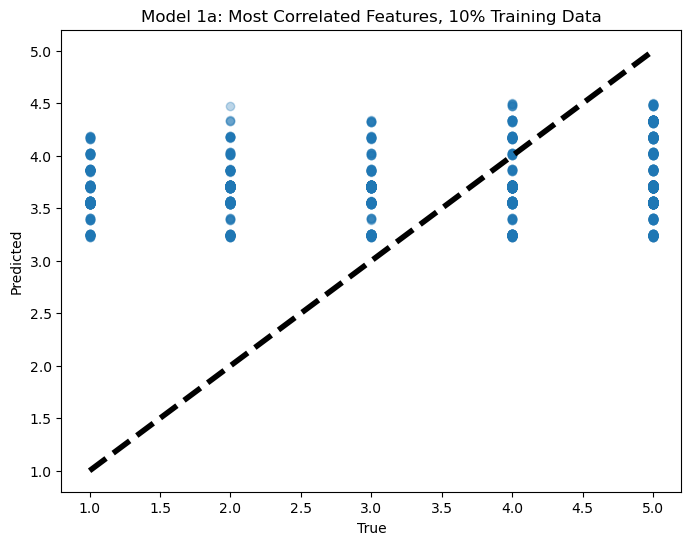

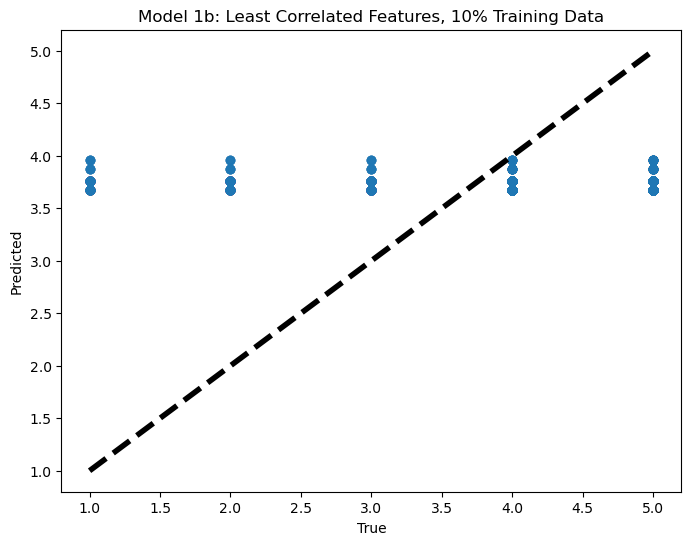

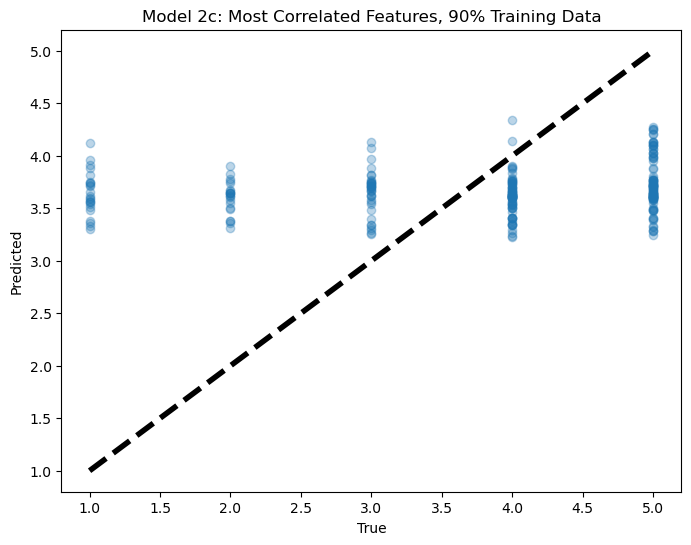

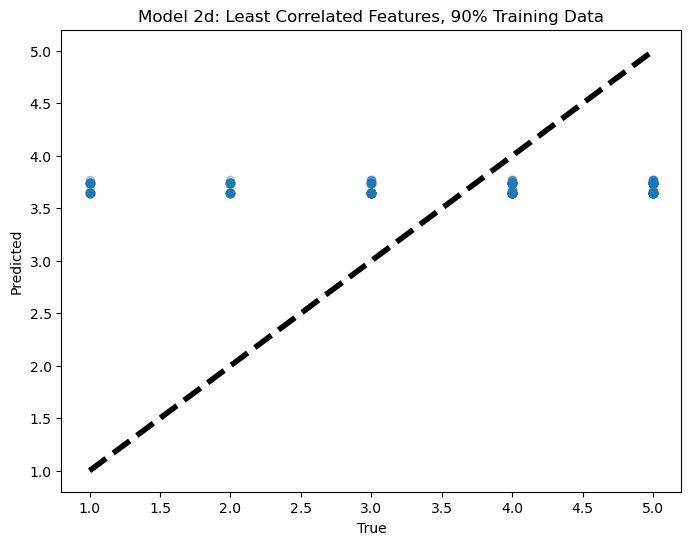

In [80]:
import matplotlib.pyplot as plt

def plot_predictions(y_test, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

# Generate predictions for each model
y_pred_1a = model_1a.predict(X_test_1a)
y_pred_1b = model_1b.predict(X_test_1b)
y_pred_2c = model_2c.predict(X_test_2c)
y_pred_2d = model_2d.predict(X_test_2d)

# Plot the true vs predicted values for each model
plot_predictions(y_test_1a, y_pred_1a, 'Model 1a: Most Correlated Features, 10% Training Data')
plot_predictions(y_test_1b, y_pred_1b, 'Model 1b: Least Correlated Features, 10% Training Data')
plot_predictions(y_test_2c, y_pred_2c, 'Model 2c: Most Correlated Features, 90% Training Data')
plot_predictions(y_test_2d, y_pred_2d, 'Model 2d: Least Correlated Features, 90% Training Data')

ValueError: could not convert string to float: 'M'

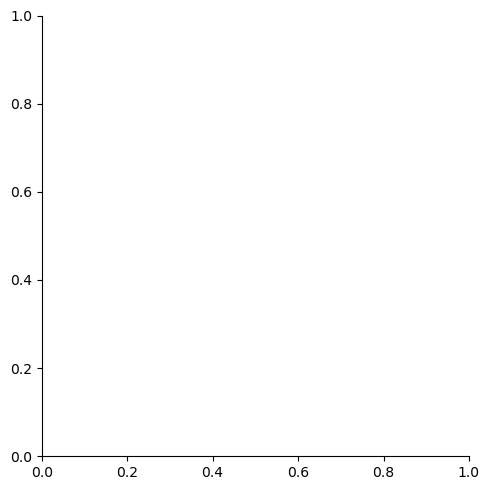

In [84]:
plt.scatter(X, predicted)
plt.xlabel('sepal_length')
plt.ylabel('predicted is_setosa')

### Data Science Ethics
*Please read the following examples [Click here to read the example_1.](https://www.vox.com/covid-19-coronavirus-us-response-trump/2020/5/18/21262265/georgia-covid-19-cases-declining-reopening) [Click here to read the example_2.](https://viborc.com/ethics-and-ethical-data-visualization-a-complete-guide/)

*Then view the picture ![My Image](figure_portfolio2.png "This is my image")
Please compose an analysis of 100-200 words that evaluates potential ethical concerns associated with the infographic, detailing the reasons behind these issues.
